In [1]:
import pandas as pd
import numpy as np
import re
from geopy.distance import geodesic

from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, STAMEN_TONER, CARTODBPOSITRON_RETINA
from bokeh.models import HoverTool, FreehandDrawTool, BoxEditTool, ColumnDataSource, ColorBar
from bokeh.palettes import Plasma10
from bokeh.transform import linear_cmap

In [2]:
# Define function to switch from lat/long to mercator x/y coordinates
def to_mercator(lat, lon):
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)

In [3]:
geo = pd.read_csv('sectors.csv', index_col='PID')
geo.shape

(2624, 6)

In [4]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
data.shape

(2579, 81)

In [5]:
map_data = geo.merge(np.round(data[['SalePrice']]/1000),how='left',on='PID')
map_data = map_data.reset_index()
map_data.drop_duplicates(subset='PID' ,inplace=True)
map_data = map_data.set_index('PID')

In [6]:
# Ames, Iowa lat long, converted to mercator
Ames_center = to_mercator(42.034534, -93.620369)

In [7]:
landmarks = {'landmarks':['Iowa State University',
                          'Municipal Airport',
                          'North Grand Mall',
                          'Mary Greeley Medical Center',
                          'Jack Trice Stadium',
                          'Walmart Supercenter'],
            'x_merc':[to_mercator(42.0267,-93.6465)[0],
                      to_mercator(41.9987,-93.6223)[0],
                      to_mercator(42.0494,-93.6224)[0],
                      to_mercator(42.0323,-93.6111)[0],
                      to_mercator(42.0140,-93.6359)[0],
                      to_mercator(42.0160016, -93.6068719)[0]],
            'y_merc':[to_mercator(42.0267,-93.6465)[1],
                      to_mercator(41.9987,-93.6223)[1],
                      to_mercator(42.0494,-93.6224)[1],
                      to_mercator(42.0323,-93.6111)[1],
                      to_mercator(42.0140,-93.6359)[1],
                      to_mercator(42.0160016, -93.6068719)[1]]}

marks = pd.DataFrame(landmarks)

In [8]:
# Set color mapping for House Prices
mycolors = linear_cmap(field_name='SalePrice', palette=Plasma10[::-1] ,low=min(map_data.SalePrice) ,high=max(map_data.SalePrice))

In [9]:
background = get_provider(CARTODBPOSITRON_RETINA) #CARTODBPOSITRON_RETINA, STAMEN_TONER
x_zoom = 7000
y_zoom = 5000

# Base Map Layer
fig = figure(plot_width=1200, plot_height=800,
             x_range=(Ames_center[0]-x_zoom, Ames_center[0]+y_zoom), 
             y_range=(Ames_center[1]-x_zoom, Ames_center[1]+y_zoom),
             x_axis_type="mercator", y_axis_type="mercator",
             title="Ames Iowa Housing Map")
fig.add_tile(background)


# Dots for Houses
my_hover = HoverTool(names=['House'])
my_hover.tooltips = [('Price', '@SalePrice')]
fig.circle(x="x_merc", y="y_merc",
           size=5,
           fill_color=mycolors, line_color=mycolors,
           fill_alpha=0.6,
           name='House',
           source=map_data)
fig.add_tools(my_hover)

# Big Dots for Landmarks, with Hover interactivity
my_hover = HoverTool(names=['landmark'])
my_hover.tooltips = [('X', '@landmarks')]
fig.circle(x="x_merc", y="y_merc",
           size=12,
           fill_color="dodgerblue", line_color='dodgerblue',
           fill_alpha=0.3,
           name='landmark',
           source=marks)
fig.add_tools(my_hover)

color_bar = ColorBar(color_mapper=mycolors['transform'], width=8,  location=(0,0),title="Price $(thousands)")
fig.add_layout(color_bar, 'right')



# Add draw tool
renderer = fig.multi_line([[1, 9]], [[5, 5]], line_width=4, alpha=0.4, color='red')
draw_tool = FreehandDrawTool(renderers=[renderer], num_objects=4)
fig.add_tools(draw_tool)

show(fig)

![walmart](Walmart.png)

## Cheaper Houses closer to Walmart Supercenter??

In [10]:
# convert lat_long string values to float
map_data['lat_long'] = [re.findall('(-*\d+.\d+)',each) for each in map_data.lat_long]

In [11]:
map_data['latitude'] = [float(each[0]) if each != [] else 0 for each in map_data.lat_long]
map_data['longitude'] = [float(each[1]) if each != [] else 0 for each in map_data.lat_long]

In [12]:
# calculate distance from Walmart (in km)
walmart = (42.0160016, -93.6068719)

In [13]:
map_data['DfromWalmart'] = [geodesic(each,walmart).miles for each in zip(map_data.latitude,map_data.longitude)]
map_data.drop('lat_long', axis=1, inplace=True)

In [14]:
# lots of missing latitute and longitudes
map_data[map_data.DfromWalmart>10].DfromWalmart.count()

103

In [15]:
map_data[['latitude','longitude']] = map_data[['latitude','longitude']].replace(0, np.NaN)

In [16]:
# use 'Neighborhood' to give an estimate of lat_long
geofill = pd.DataFrame({'lat':map_data.groupby('Neighborhood').latitude.mean(),
                        'long':map_data.groupby('Neighborhood').longitude.mean()})

In [17]:
# missing Neighborhood info
geofill.loc['Blueste'] = [42.009757, -93.647011]
geofill.loc['GrnHill'] = [42.001514, -93.644726]
geofill.loc['Landmrk'] = [42.021237, -93.682435]
geofill

,lat,long
Neighborhood,,
Blmngtn,42.062741,-93.641574
Blueste,42.009757,-93.647011
BrDale,42.052066,-93.628499
BrkSide,42.032397,-93.624965
ClearCr,42.028353,-93.671574
CollgCr,42.018940,-93.686806
Crawfor,42.015655,-93.641099
Edwards,42.022026,-93.666746
Gilbert,42.059764,-93.639265


In [18]:
map_data.loc[map_data.DfromWalmart>100,'latitude'] = \
    map_data[map_data.DfromWalmart>100].apply(lambda r: geofill.loc[r.Neighborhood].lat, axis=1)
map_data.loc[map_data.DfromWalmart>100,'longitude'] = \
    map_data[map_data.DfromWalmart>100].apply(lambda r: geofill.loc[r.Neighborhood].long, axis=1)

In [19]:
# recalc Distance from Walmart
map_data['DfromWalmart'] = [geodesic(each,walmart).miles for each in zip(map_data.latitude,map_data.longitude)]
map_data[map_data.DfromWalmart>100] # Should be NONE

,x_merc,y_merc,Neighborhood,Sector,Color,SalePrice,latitude,longitude,DfromWalmart
PID,,,,,,,,,


## Distance from <span style="color:teal">Walmart</span>? 🏪

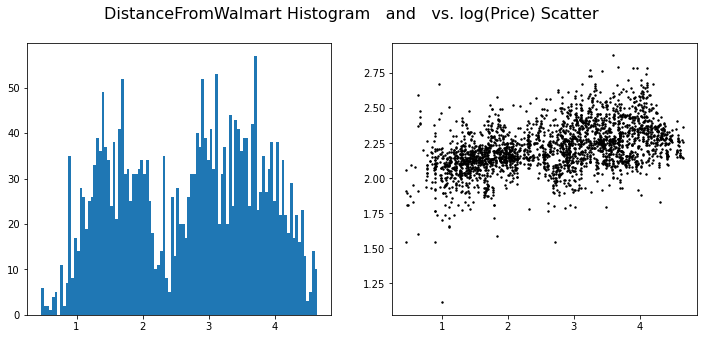

In [20]:
import matplotlib.pyplot as plt
#Plot MasVnrArea
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('DistanceFromWalmart Histogram   and   vs. log(Price) Scatter', size=16)

ax1.hist(map_data.DfromWalmart, bins=100)
ax2.scatter(x=map_data.DfromWalmart,y=np.log10(map_data.SalePrice),s=2,c='k')

In [21]:
map_data.to_csv('sectors_walmart.csv')

In [22]:
map_data.head()

,x_merc,y_merc,Neighborhood,Sector,Color,SalePrice,latitude,longitude,DfromWalmart
PID,,,,,,,,,
909176150,-1.042525e+07,5.163761e+06,SWISU,SW,purple,126.0,42.018564,-93.651619,2.309798
905476230,-1.042659e+07,5.164703e+06,Edwards,SW,purple,140.0,42.024855,-93.663671,2.986330
911128020,-1.042107e+07,5.164208e+06,IDOTRR,DT,dodgerblue,125.0,42.021548,-93.614068,0.532618
535377150,-1.042086e+07,5.166582e+06,OldTown,DT,dodgerblue,114.0,42.037391,-93.612207,1.501598
534177230,-1.042305e+07,5.167656e+06,NWAmes,NO,green,227.0,42.044554,-93.631818,2.351831


### add LabelEncoded Neighborhood and Sector data for mapping on the <span style="color:teal">APP</span>

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [52]:
map_data['le_Neighbor'] = le.fit_transform(map_data.Neighborhood)
map_data['le_Sector'] = le.fit_transform(map_data.Sector)

In [53]:
map_data.to_csv('APP_data.csv')

## Try K-means to group Houses by Location (lat-long) and SalePrice

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans()

In [24]:
inertias = {}
for n in range(5,29):
    kmeans.set_params(n_clusters=n)
    kmeans.fit(map_data[['latitude','longitude','SalePrice']])
    inertias[n] = kmeans.inertia_

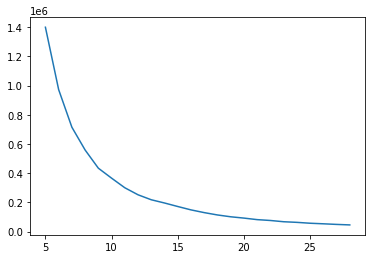

In [25]:
plt.plot(inertias.keys(),inertias.values())  # Will go with 10

In [26]:
kmeans.set_params(n_clusters=8)
kmeans.fit(map_data[['latitude','longitude','SalePrice']])

KMeans()

In [27]:
map_data = map_data.reset_index().merge(pd.DataFrame(kmeans.labels_), left_index=True, right_index=True).set_index('PID')

In [28]:
map_data.rename(columns={0:'K_neighbor'}, inplace=True)
map_data.head()

,x_merc,y_merc,Neighborhood,Sector,Color,SalePrice,latitude,longitude,DfromWalmart,K_neighbor
PID,,,,,,,,,,
909176150,-1.042525e+07,5.163761e+06,SWISU,SW,purple,126.0,42.018564,-93.651619,2.309798,0
905476230,-1.042659e+07,5.164703e+06,Edwards,SW,purple,140.0,42.024855,-93.663671,2.986330,0
911128020,-1.042107e+07,5.164208e+06,IDOTRR,DT,dodgerblue,125.0,42.021548,-93.614068,0.532618,0
535377150,-1.042086e+07,5.166582e+06,OldTown,DT,dodgerblue,114.0,42.037391,-93.612207,1.501598,5
534177230,-1.042305e+07,5.167656e+06,NWAmes,NO,green,227.0,42.044554,-93.631818,2.351831,2


In [50]:
# Set color mapping for K-means Neighbors
mycolors = linear_cmap(field_name='le_Neighbor', palette=Plasma10[::-1] ,low=min(map_data.le_Neighbor) ,high=max(map_data.le_Neighbor))

In [51]:
background = get_provider(CARTODBPOSITRON_RETINA) #CARTODBPOSITRON_RETINA, STAMEN_TONER
x_zoom = 7000
y_zoom = 5000

# Base Map Layer
fig = figure(plot_width=1200, plot_height=800,
             x_range=(Ames_center[0]-x_zoom, Ames_center[0]+y_zoom), 
             y_range=(Ames_center[1]-x_zoom, Ames_center[1]+y_zoom),
             x_axis_type="mercator", y_axis_type="mercator",
             title="Ames Iowa Housing Map")
fig.add_tile(background)


# Dots for Houses
my_hover = HoverTool(names=['House'])
my_hover.tooltips = [('Price', '@SalePrice')]
fig.circle(x="x_merc", y="y_merc",
           size=5,
           fill_color=mycolors, line_color=mycolors,
           fill_alpha=0.6,
           name='House',
           source=map_data)
fig.add_tools(my_hover)

# Big Dots for Landmarks, with Hover interactivity
my_hover = HoverTool(names=['landmark'])
my_hover.tooltips = [('X', '@landmarks')]
fig.circle(x="x_merc", y="y_merc",
           size=12,
           fill_color="dodgerblue", line_color='dodgerblue',
           fill_alpha=0.3,
           name='landmark',
           source=marks)
fig.add_tools(my_hover)

color_bar = ColorBar(color_mapper=mycolors['transform'], width=8,  location=(0,0),title="Price $(thousands)")
fig.add_layout(color_bar, 'right')

show(fig)